# Pipeline

#### Tópicos da aula
- Transformers x Estimators
- Pipeline
- FunctionTransform
- ColumnTransform

___________________________


[Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) é uma classe do sklearn que permite aplicar uma sequência de transformações em um estimador final. <br>
Para isso, os passos intermediários devem ter implementados métodos de `fit` e `transform` enquanto o estimador final só precisa ter o `fit` implementado. <br>
O propósito do `pipeline` é:
- reunir várias etapas para serem validadas de forma cruzada (cross-validation) ao definir parâmetros diferentes
- ajudar a criar códigos que possuam um padrão que possa ser facilmente entendido e compartilhando entre times de cientista e engenheiro de dados.

<img src="images/pipeline.png" text="https://nbviewer.org/github/rasbt/python-machine-learning-book/blob/master/code/ch06/ch06.ipynb#Combining-transformers-and-estimators-in-a-pipeline">



- __Transformer:__ Um transformador se refere à um objeto de uma classe que possuim os métodos fit() e transform() e que nos ajudam a transformar o dado na forma que queremos. OneHotEncoder, SimpleImputer e MinMaxScaler são exemplos de transformers.
- __Estimator:__ Um estimador se refere à um algoritmo de ML. Ele é um objeto de uma classe que possui os métodos fit() e predict(). [Aqui](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) se encontram exemplos de estimadores.

Hoje vamos utilizar um dataset mais simples de exemplo. Usaremos os dados de gorjeta cuja descrição encontra-se [nesse link](https://vincentarelbundock.github.io/Rdatasets/doc/reshape2/tips.html).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Vamos importar o dataset
df = sns.load_dataset('tips')

# Add missing values -> pra dar uma graça no dataset
df.iloc[[1, 2, 4, 12], [2]] = np.nan
df.iloc[[10, 20, 40, 120, 222], [1]] = np.nan
df.iloc[[61, 27, 145, 212], [3]] = np.nan
df.iloc[[143, 237, 48, 102, 20], [4]] = np.nan
df.iloc[[71, 172, 194, 182], [5]] = np.nan
df.iloc[[83, 90, 33, 228], [6]] = np.nan
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2.0
1,10.34,1.66,NaN,No,Sun,Dinner,3.0
2,21.01,3.50,NaN,No,Sun,Dinner,3.0
3,23.68,3.31,Male,No,Sun,Dinner,2.0
4,24.59,3.61,NaN,No,Sun,Dinner,4.0
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3.0
240,27.18,2.00,Female,Yes,Sat,Dinner,2.0
241,22.67,2.00,Male,Yes,Sat,Dinner,2.0
242,17.82,1.75,Male,No,Sat,Dinner,2.0


In [3]:
# Vamos ver as dimensões dele
df.shape

(244, 7)

In [4]:
# Observe que cada feature tem pelo menos 1 nulo (afinal, non-null delas é menor que 150)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         239 non-null    float64 
 2   sex         240 non-null    category
 3   smoker      240 non-null    category
 4   day         239 non-null    category
 5   time        240 non-null    category
 6   size        240 non-null    float64 
dtypes: category(4), float64(3)
memory usage: 7.4 KB


In [5]:
# Confirmando quantos nulos temos em cada coluna
df.isnull().sum()

total_bill    0
tip           5
sex           4
smoker        4
day           5
time          4
size          4
dtype: int64

Para as minhas features numéricas, eu quero seguir os seguintes passos de pré-processamento,
1. "padronizar" as minhas features (ou "normalizar", deixar elas com média 0 e desvio padrão 1),
2. adicionar a mediana em qualquer valor nulo,
3. treinar o algoritmo de ML.

Neste caso, note que eu preciso "treinar" os passos (1), (2) e (3) todos na base de treino, e depois só aplicar eles na base de validação.

In [8]:
# particionando os dados
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['total_bill']), 
                                                    df['total_bill'], 
                                                    test_size=.2, 
                                                    random_state=42)

In [9]:
# Para os passos de processamento das features, faremos todos juntos, com um Pipeline.
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

Como utilizar: <br>
O Pipeline é construído com uma lista de pares (key, value) nos quais a key é uma string que contém um nome para o step escolhido e o valor é o objeto da classe:

<img src="images/pipeline_sintaxe.png" width=500 />

tal que `transformacao_1` é o nome que você quer dar para essa etapa e `transformacao_1()` é a classe instanciada da transformação.
A lista com as transformações deve ser passada já com a sequencia em que elas devem ser aplicadas.
<br>
O Pipeline segue o mesmo framework do sklearn e por isso temos os métodos `.fit()`, `fit_transform()` e `.transform()` para os transformes e `.fit()` e `predict()` quando temos estimadores definidos dentro da sequência do pipeline.

In [25]:
# Separa variáveis numéricas das categóricas
num_cols = X_train.select_dtypes("number").columns
cat_cols = X_train.select_dtypes(exclude="number").columns

# Cria nosso Pipeline com SimpleImputer, StandardScaler e KNeighborsRegressor
pipe_knn = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor(n_neighbors=7))
], verbose=2)

Os passos do pipeline podem ser acessados pelos índices ou passando a key:

In [17]:
# por índice
pipe_knn[1]

StandardScaler()

In [19]:
# por key
pipe_knn['imputer']

SimpleImputer(strategy='median')

In [22]:
pipe_knn.get_params()

{'memory': None,
 'steps': [('imputer', SimpleImputer(strategy='median')),
  ('scaler', StandardScaler()),
  ('model', KNeighborsRegressor(n_neighbors=7))],
 'verbose': True,
 'imputer': SimpleImputer(strategy='median'),
 'scaler': StandardScaler(),
 'model': KNeighborsRegressor(n_neighbors=7),
 'imputer__add_indicator': False,
 'imputer__copy': True,
 'imputer__fill_value': None,
 'imputer__missing_values': nan,
 'imputer__strategy': 'median',
 'imputer__verbose': 0,
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'model__algorithm': 'auto',
 'model__leaf_size': 30,
 'model__metric': 'minkowski',
 'model__metric_params': None,
 'model__n_jobs': None,
 'model__n_neighbors': 7,
 'model__p': 2,
 'model__weights': 'uniform'}

In [23]:
# Podemos visualizar nosso pipe
from sklearn import set_config
set_config(display="diagram")
pipe_knn  # click on the diagram below to see the details of each step

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model', KNeighborsRegressor(n_neighbors=7))],
         verbose=True)

In [26]:
# Vamos rodar nosso pipeline no treino utilizando apenas as colunas numéricas
pipe_knn.fit(X_train[num_cols], y_train)

[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model', KNeighborsRegressor(n_neighbors=7))],
         verbose=2)

In [28]:
# Fazendo o predict direto:
y_pred = pipe_knn.predict(X_test[num_cols])
y_pred

array([23.74428571, 13.05571429, 25.39285714, 32.95571429, 13.05571429,
       13.05571429, 13.87      , 14.19142857, 22.42714286, 20.07      ,
       20.07      , 13.45571429, 14.96428571, 13.05571429, 11.73428571,
       24.08428571, 24.81      , 18.56714286, 13.48857143, 30.34571429,
       13.48857143, 24.59571429, 18.56714286, 13.45571429, 25.13857143,
       20.07      , 20.07      , 21.24571429, 25.39285714, 29.3       ,
       24.81      , 13.45571429, 25.39285714, 23.74428571, 25.13857143,
       27.28428571, 14.96428571, 33.14285714, 16.70428571, 13.05571429,
       14.21428571, 13.05571429, 14.19142857, 24.08428571, 13.05571429,
       13.83285714, 13.58857143, 25.12      , 13.45571429])

In [29]:
# Agora avaliamos o modelo no nosso conjunto de validação.
print(f'MSE: {mean_squared_error(y_test, y_pred):.1f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.1f}')

MSE: 50.1
MAE: 5.9


In [32]:
X_train[num_cols].head()

,tip,size
228,2.72,NaN
208,2.03,2.0
96,4.00,2.0
167,4.50,4.0
84,2.03,2.0


In [31]:
################################### caso sem o estimador

# Cria nosso Pipeline com SimpleImputer, StandardScaler e KNeighborsRegressor
pipe_knn2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
], verbose=2)

pipe_knn2.fit(X_train[num_cols])
pipe_knn2.transform(X_test[num_cols])

[Pipeline] ........... (step 1 of 2) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing scaler, total=   0.0s


array([[ 0.06219341, -0.61214068],
       [-0.76885788, -0.61214068],
       [-0.76885788,  1.51942062],
       [ 1.4566693 ,  1.51942062],
       [-0.76885788, -0.61214068],
       [-0.76885788, -0.61214068],
       [-0.37446066, -0.61214068],
       [-0.40263189, -0.61214068],
       [ 0.09740745, -0.61214068],
       [-0.06457713, -0.61214068],
       [-0.06457713, -0.61214068],
       [-1.14212668, -0.61214068],
       [-1.12099826, -0.61214068],
       [-0.76885788, -0.61214068],
       [-0.88858561, -1.67792133],
       [-1.21959756,  0.45363997],
       [ 0.63970363,  0.45363997],
       [ 0.58336117, -0.61214068],
       [-0.43784593, -0.61214068],
       [ 1.34398438,  2.58520127],
       [-0.45193154, -0.61214068],
       [ 0.18192114,  0.45363997],
       [ 0.63970363, -0.61214068],
       [-1.1562123 , -0.61214068],
       [ 0.28756325,  0.45363997],
       [-0.06457713, -0.61214068],
       [-0.06457713, -0.61214068],
       [ 1.34398438, -0.61214068],
       [-0.76885788,

In [ ]:
# Tudo junto
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error


# particionando os dados
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['total_bill']), 
    df['total_bill'], 
    test_size=.2, 
    random_state=42
)

# Define variáveis numéricas e categóricas
num_cols = X_train.select_dtypes("number").columns
cat_cols = X_train.select_dtypes(exclude="number").columns

# Cria nosso Pipeline com SimpleImputer, StandardScaler e KNeighborsRegressor
pipe_knn = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor(n_neighbors=7))],
    verbose=True
)

# Vamos rodar nosso pipeline no treino
pipe_knn.fit(X_train[num_cols], y_train)

# Prediz no teste
y_pred = pipe_knn.predict(X_test[num_cols])

print()
print(y_pred[:10])
print()

# Agora avaliamos o modelo no nosso conjunto de validação.
print(f'MSE: {mean_squared_error(y_test, y_pred):.1f}')
print(f'MAE: {mean_absolute_error(y_test, y_pred):.1f}')

Por que isso é poderoso?

Imagina se quiséssemos fazer validação cruzada. Nesse caso, em cada fold que escolhermos como validação, teriamos que refazer cada passo na base de treino da vez,
1. achar a mediana daquela base de treino, e preencher os nulos,
2. achar a média e a variância daquela base de treino, para padronizar as features,
3. aí sim, treinamos o modelo na base de treino, e medimos a qualidade no fold de validação da vez.

Mas usando Pipeline, a gente não precisa fazer tudo passo a passo. O Pipeline se encarrega de fazer tudo de uma vez para nós. É como se o nosso "modelo" agora fosse o pipeline completo. 

In [34]:
from sklearn.model_selection import cross_validate
cross_validate(pipe_knn, X_train[num_cols], y_train, cv=3, verbose=2, scoring='neg_mean_absolute_error')

[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
[CV] END .................................................... total time=   0.0s
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
[CV] END .................................................... total time=   0.0s
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


{'fit_time': array([0.00475597, 0.00297952, 0.00391912]),
 'score_time': array([0.00159216, 0.00186896, 0.00177741]),
 'test_score': array([-4.44538462, -4.91756044, -5.56026374])}

### Tunando hiperparâmetros

In [35]:
# Vamos checar quais os parâmetros que podemos utilizar
pipe_knn.get_params()

{'memory': None,
 'steps': [('imputer', SimpleImputer(strategy='median')),
  ('scaler', StandardScaler()),
  ('model', KNeighborsRegressor(n_neighbors=7))],
 'verbose': 2,
 'imputer': SimpleImputer(strategy='median'),
 'scaler': StandardScaler(),
 'model': KNeighborsRegressor(n_neighbors=7),
 'imputer__add_indicator': False,
 'imputer__copy': True,
 'imputer__fill_value': None,
 'imputer__missing_values': nan,
 'imputer__strategy': 'median',
 'imputer__verbose': 0,
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'model__algorithm': 'auto',
 'model__leaf_size': 30,
 'model__metric': 'minkowski',
 'model__metric_params': None,
 'model__n_jobs': None,
 'model__n_neighbors': 7,
 'model__p': 2,
 'model__weights': 'uniform'}

In [36]:
# Tunando hiperparâmetros com 3-fold cross-validation e pipelines
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

params_grid = { 
 'model__n_neighbors': [3, 5, 7, 9],
 'model__p': [1, 2],
 'model__weights': ['uniform', 'distance']}

fold = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe_knn, param_grid=params_grid, scoring='neg_mean_absolute_error', cv = fold, verbose=2)

grid.fit(X_train[num_cols], y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
[CV] END model__n_neighbors=3, model__p=1, model__weights=uniform; total time=   0.0s
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
[CV] END model__n_neighbors=3, model__p=1, model__weights=uniform; total time=   0.0s
[Pipeline] ........... (step 1 of 3) Processing imputer, total=   0.0s
[Pipeline] ............ (step 2 of 3) Processing scaler, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.0s
[CV] END model__n_neighbors=3, model__p=1, model__weights=uniform; total time=   0.0s
[Pipeline] ........... (step 1 of 3) Proce

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        KNeighborsRegressor(n_neighbors=7))],
                                verbose=2),
             param_grid={'model__n_neighbors': [3, 5, 7, 9], 'model__p': [1, 2],
                         'model__weights': ['uniform', 'distance']},
             scoring='neg_mean_absolute_error', verbose=2)

In [37]:
# Agora podemos acessar os atributos do grid
grid.best_score_

-4.592695970695971

In [38]:
grid.best_params_

{'model__n_neighbors': 7, 'model__p': 1, 'model__weights': 'uniform'}

In [40]:
y_pred = grid.best_estimator_.predict(X_test[num_cols])
y_pred

array([23.74428571, 13.05571429, 25.39285714, 32.95571429, 13.05571429,
       13.05571429, 13.87      , 14.19142857, 22.42714286, 20.07      ,
       20.07      , 13.45571429, 14.96428571, 13.05571429, 11.73428571,
       24.08428571, 24.81      , 18.56714286, 13.48857143, 30.34571429,
       13.48857143, 24.59571429, 18.56714286, 13.45571429, 25.13857143,
       20.07      , 20.07      , 21.24571429, 25.39285714, 29.55428571,
       24.81      , 13.45571429, 25.39285714, 23.74428571, 25.13857143,
       27.28428571, 14.96428571, 33.14285714, 16.70428571, 13.05571429,
       14.21428571, 13.05571429, 14.19142857, 24.08428571, 13.05571429,
       13.83285714, 13.58857143, 25.12      , 13.45571429])

E se eu tiver funções próprias ou queira aplicar alguma pronta do python?

## [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html)
Com a `FunctionTransformer` conseguimos adicionar funções que não possuem os métodos `.fit()` e `.transform()` ao pipeline. A função criada deve retornar um pandas Dataframe ou um array do numpy a fim de podermos utilizá-lo com o Pipelines.

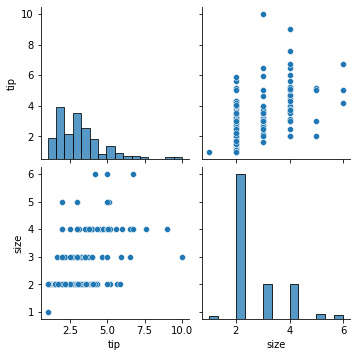

In [41]:
sns.pairplot(data=X_train)

In [52]:
from sklearn.preprocessing import FunctionTransformer

# Para funções próprias
def somar_10(df):
    return df+10

def quebra_coluna(df):
    df['tip2'] = np.where(df['tip']<5, 0, 1)
    return df

def return_selected_cols(dataset, columns):
    return dataset[columns]

pipe_knn_cv = Pipeline([
    ('somar_10', FunctionTransformer(somar_10)),
    ('quebra_coluna', FunctionTransformer(quebra_coluna)),
    ('return_selected_cols', FunctionTransformer(return_selected_cols, kw_args={'columns':['tip', 'size']})),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', KNeighborsRegressor(n_neighbors=7))],
    verbose=True
)

pipe_knn_cv.fit(X_train[num_cols], y_train)

[Pipeline] .......... (step 1 of 6) Processing somar_10, total=   0.0s
[Pipeline] ..... (step 2 of 6) Processing quebra_coluna, total=   0.0s
[Pipeline]  (step 3 of 6) Processing return_selected_cols, total=   0.0s
[Pipeline] ........... (step 4 of 6) Processing imputer, total=   0.0s
[Pipeline] ............ (step 5 of 6) Processing scaler, total=   0.0s
[Pipeline] ............. (step 6 of 6) Processing model, total=   0.0s


Pipeline(steps=[('somar_10',
                 FunctionTransformer(func=<function somar_10 at 0x7f42881af280>)),
                ('quebra_coluna',
                 FunctionTransformer(func=<function quebra_coluna at 0x7f42881af430>)),
                ('return_selected_cols',
                 FunctionTransformer(func=<function return_selected_cols at 0x7f42881c0a60>,
                                     kw_args={'columns': ['tip', 'size']})),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model', KNeighborsRegressor(n_neighbors=7))],
         verbose=True)

In [ ]:
# auala de segunda trazer de volta nome das colunas
#pipe_knn_cv['imputer'].get_feature_names_out(X_train[num_cols])

In [57]:
pipe_knn_cv['quebra_coluna'].transform(X_test[num_cols].copy())

,tip,size,tip2
24,3.18,2.0,0
6,2.00,2.0,0
153,2.00,4.0,0
211,5.16,4.0,1
198,2.00,2.0,0
176,2.00,2.0,0
192,2.56,2.0,0
124,2.52,2.0,0
9,3.23,2.0,0
101,3.00,2.0,0


In [58]:
pipe_knn_cv['return_selected_cols'].transform(X_test[num_cols])

,tip,size
24,3.18,2.0
6,2.00,2.0
153,2.00,4.0
211,5.16,4.0
198,2.00,2.0
176,2.00,2.0
192,2.56,2.0
124,2.52,2.0
9,3.23,2.0
101,3.00,2.0


In [59]:
pipe_knn_cv['imputer'].transform(X_test[num_cols])

array([[ 3.18,  2.  ],
       [ 2.  ,  2.  ],
       [ 2.  ,  4.  ],
       [ 5.16,  4.  ],
       [ 2.  ,  2.  ],
       [ 2.  ,  2.  ],
       [ 2.56,  2.  ],
       [ 2.52,  2.  ],
       [ 3.23,  2.  ],
       [ 3.  ,  2.  ],
       [ 3.  ,  2.  ],
       [ 1.47,  2.  ],
       [ 1.5 ,  2.  ],
       [ 2.  ,  2.  ],
       [ 1.83,  1.  ],
       [ 1.36,  3.  ],
       [ 4.  ,  3.  ],
       [ 3.92,  2.  ],
       [ 2.47,  2.  ],
       [ 5.  ,  5.  ],
       [ 2.45, 12.  ],
       [ 3.35,  3.  ],
       [ 4.  ,  2.  ],
       [ 1.45,  2.  ],
       [ 3.5 ,  3.  ],
       [13.  ,  2.  ],
       [13.  ,  2.  ],
       [ 5.  ,  2.  ],
       [ 2.  ,  4.  ],
       [ 5.  ,  6.  ],
       [ 4.  ,  3.  ],
       [ 1.44,  2.  ],
       [ 2.34,  4.  ],
       [ 3.21,  2.  ],
       [ 3.5 ,  3.  ],
       [ 2.92,  4.  ],
       [ 1.5 ,  2.  ],
       [ 5.  ,  4.  ],
       [ 2.75,  2.  ],
       [ 2.  ,  2.  ],
       [ 1.25,  2.  ],
       [ 2.  ,  2.  ],
       [ 2.55,  2.  ],
       [ 1.

In [60]:
pipe_knn_cv['scaler'].transform(X_test[num_cols])

/home/patricia/Documentos/escritorio_dados/venv/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


array([[ -6.98061413, -11.2699472 ],
       [ -7.81166542, -11.2699472 ],
       [ -7.81166542,  -9.1383859 ],
       [ -5.58613824,  -9.1383859 ],
       [ -7.81166542, -11.2699472 ],
       [ -7.81166542, -11.2699472 ],
       [ -7.41726819, -11.2699472 ],
       [ -7.44543942, -11.2699472 ],
       [ -6.94540009, -11.2699472 ],
       [ -7.10738466, -11.2699472 ],
       [ -7.10738466, -11.2699472 ],
       [ -8.18493422, -11.2699472 ],
       [ -8.16380579, -11.2699472 ],
       [ -7.81166542, -11.2699472 ],
       [ -7.93139314, -12.33572785],
       [ -8.2624051 , -10.20416655],
       [ -6.40310391, -10.20416655],
       [ -6.45944637, -11.2699472 ],
       [ -7.48065346, -11.2699472 ],
       [ -5.69882316,  -8.07260524],
       [ -7.49473908,          nan],
       [ -6.8608864 , -10.20416655],
       [ -6.40310391, -11.2699472 ],
       [ -8.19901983, -11.2699472 ],
       [ -6.75524429, -10.20416655],
       [         nan, -11.2699472 ],
       [         nan, -11.2699472 ],
 

E como adicionar tratamento nas variáveis categóricas?

## [ColumnTransformer()](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html?highlight=columntransformer#sklearn.compose.ColumnTransformer)
Essa classe serve para __especificarmos em quais colunas a transformação deve ser aplicada__. Seu uso é bem simples, deve-se nomear o tratamento, especificar qual ele deve ser e especificar as colunas nas quais ele deve ser aplicado.

In [62]:
pipe_knn.fit(X_train, y_train)

ValueError: Cannot use median strategy with non-numeric data:
could not convert string to float: 'Male'

In [65]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

# Separa treino e teste
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['total_bill']), 
                                                    df['total_bill'], 
                                                    test_size=.2, 
                                                    random_state=42)

# Define colunas categóricas
cat_cols = list(X_train.select_dtypes('category').columns)
print(f"Colunas categoricas: {cat_cols}")

# Define colunas numéricas
num_cols = list(X_train.select_dtypes('number').columns)
print(f"Colunas numéricas: {num_cols}")

# Para funções próprias
def somar_10(df):
    return df+10

soma_10 = FunctionTransformer(somar_10, validate=False)

# Define pipeline numérico
num_pipe = Pipeline([
    ('imputer_cv', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(np.log)),
    ('soma10', soma_10),
    ('scaler_cv', StandardScaler()),
], verbose=True)

# Define pipeline categórico com SimpleImputer e OneHotEncoder
cat_pipe = Pipeline([
    ('imputer_cv', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first')),
])

# Concatena pipelines categóricos e numéricos com suas respectivas colunas
preprocessor = ColumnTransformer([
    ('num_pipe', num_pipe, num_cols),
    ('cat_pipe', cat_pipe, cat_cols)
])

# Define pipeline final com o preprocessor e o estimador
pipeline = Pipeline([
    ('prepocessor', preprocessor),
    ('model', KNeighborsRegressor(n_neighbors=7))
])


# Tunando hiperparâmetros com 3-fold cross-validation e pipelines
parameters = {'model__n_neighbors': [3, 4, 5],
              'model__p': [1,2],
              'model__weights': ["uniform", "distance"]}

kfold = KFold(n_splits=3, shuffle=True, random_state=42)
grid = GridSearchCV(pipeline, param_grid=parameters, cv=kfold, n_jobs=-1, return_train_score=True, scoring="neg_mean_squared_error")

grid.fit(X_train, y_train)

Colunas categoricas: ['sex', 'smoker', 'day', 'time']
Colunas numéricas: ['tip', 'size']
[Pipeline] ........ (step 1 of 4) Processing imputer_cv, total=   0.0s
[Pipeline] ............... (step 2 of 4) Processing log, total=   0.0s
[Pipeline] ............ (step 3 of 4) Processing soma10, total=   0.0s
[Pipeline] ......... (step 4 of 4) Processing scaler_cv, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing imputer_cv, total=   0.0s
[Pipeline] ............... (step 2 of 4) Processing log, total=   0.0s
[Pipeline] ............ (step 3 of 4) Processing soma10, total=   0.0s
[Pipeline] ......... (step 4 of 4) Processing scaler_cv, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing imputer_cv, total=   0.0s
[Pipeline] ............... (step 2 of 4) Processing log, total=   0.0s
[Pipeline] ............ (step 3 of 4) Processing soma10, total=   0.0s
[Pipeline] ......... (step 4 of 4) Processing scaler_cv, total=   0.0s
[Pipeline] ........ (step 1 of 4) Processing imputer_cv, to

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('prepocessor',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('imputer_cv',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('log',
                                                                                          FunctionTransformer(func=<ufunc 'log'>)),
                                                                                         ('soma10',
                                                                                          FunctionTransformer(func=<function somar_10 at 0x7f42e4879c10>)),
                                                                                         ('scaler_cv',
                                                                                          Standa...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'day',
                                                                          'time'])])),
                                       ('model',
                                        KNeighborsRegressor(n_neighbors=7))]),
             n_jobs=-1,
             param_grid={'model__n_neighbors': [3, 4, 5], 'model__p': [1, 2],
                         'model__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='neg_mean_squared_error')

## Bibliografia e Aprofundamento
- [Python Machine Learning Book](https://github.com/rasbt/python-machine-learning-book-3rd-edition)
- [Documentação](https://scikit-learn.org/stable/modules/compose.html)
- [ColumnTransformer](https://scikit-learn.org/stable/modules/compose.html#columntransformer-for-heterogeneous-data)
- [FeatureUnion](https://scikit-learn.org/stable/modules/compose.html#featureunion-composite-feature-spaces)
- https://medium.com/data-hackers/como-usar-pipelines-no-scikit-learn-1398a4cc6ae9
- [Pipelines e funções próprias: FuncionTransformer](https://towardsdatascience.com/using-functiontransformer-and-pipeline-in-sklearn-to-predict-chardonnay-ratings-9b13fdd6c6fd)
- [Custom Functions: Como criar classes e usá-las no pipeline](https://tiaplagata.medium.com/how-scikit-learn-pipelines-make-your-life-so-much-easier-3cfbfa1d9da6)
- [Pipeline com PySpark](https://www.analyticsvidhya.com/blog/2019/11/build-machine-learning-pipelines-pyspark/)